In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('training_subset_dt.csv')

# Drop unnecessary columns
data = data.drop(['start_wavelength', 'end_wavelength'], axis=1)


# Create range-based features using known mineral characteristics
def create_range_features(row):
    features = {}
    
    # Alunite range features
    features['is_alunite_p_range'] = 1 if 2.165 <= row['peak_wavelength'] <= 2.195 else 0
    features['is_alunite_w_range'] = 1 if 0.2 <= row['width'] <= 0.25 else 0
    features['is_alunite_d_range'] = 1 if 0.25 <= row['depth'] <= 0.76 else 0
    features['is_alunite_as_range'] = 1 if 1.50 <= row['area_ratio'] <= 3.37 else 0
    features['is_alunite_sm_range'] = 1 if 0.73 <= row['symmetry'] <= 0.76 else 0
    
    
    # Kaolinite range features
    features['is_kaolinite_p_range'] = 1 if 2.204 <= row['peak_wavelength'] <= 2.210 else 0
    features['is_kaolinite_w_range'] = 1 if 0.14 <= row['width'] <= 0.22 else 0
    features['is_kaolinite_d_range'] = 1 if 0.15 <= row['depth'] <= 0.25 else 0
    features['is_kaolinite_as_range'] = 1 if 3.46 <= row['area_ratio'] <= 6.74 else 0
    features['is_kaolinite_sm_range'] = 1 if 0.63 <= row['symmetry'] <= 0.76 else 0
    

    # Montmorillonite range features
    features['is_montmorillonite_p_range'] = 1 if 2.204 <= row['peak_wavelength'] <= 2.220 else 0
    features['is_montmorillonite_w_range'] = 1 if 0.1 <= row['width'] <= 0.16 else 0
    features['is_montmorillonite_d_range'] = 1 if 0.01 <= row['depth'] <= 0.15 else 0
    features['is_montmorillonite_as_range'] = 1 if 0.37 <= row['area_ratio'] <= 1.47 else 0
    features['is_montmorillonite_sm_range'] = 1 if 0.31 <= row['symmetry'] <= 0.52 else 0
    
    return pd.Series(features)

# Apply range feature creation
range_features = data.apply(create_range_features, axis=1)
data = pd.concat([data, range_features], axis=1)

# Prepare features and target
basic_features = ['peak_wavelength', 'width', 'depth', 'symmetry', 'area_ratio']
range_feature_cols = [col for col in data.columns if col.startswith('is_')]
features = basic_features + range_feature_cols

X = data[features]
y = data['mineral']



In [2]:
# Encode mineral labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize Leave-One-Out and Decision Tree
loo = LeaveOneOut()
dt_model = DecisionTreeClassifier(random_state=48, max_depth=4)  # Slightly increased depth for new features

# Store predictions and true labels
predictions = []
true_labels = []

# Perform Leave-One-Out cross-validation
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    dt_model.fit(X_train, y_train)
    pred = dt_model.predict(X_test)
    
    predictions.append(pred[0])
    true_labels.append(y_test[0])



Decision Tree Accuracy: 0.9677


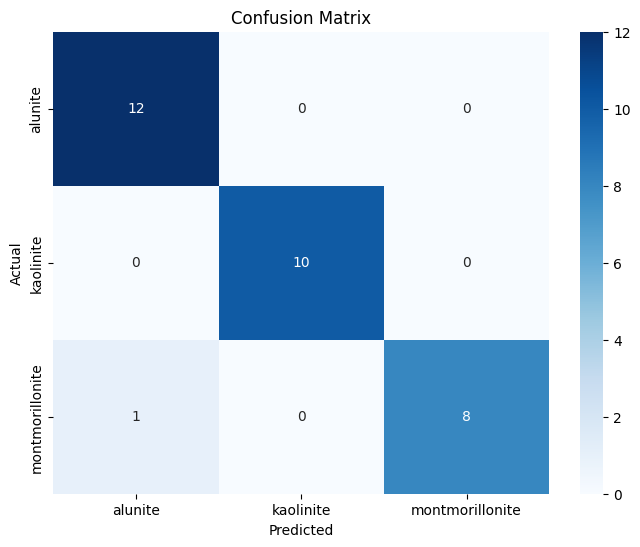


Feature Importances:
                        Feature  Importance
0               peak_wavelength     0.54955
3                      symmetry     0.45045
11         is_kaolinite_w_range     0.00000
18  is_montmorillonite_as_range     0.00000
17   is_montmorillonite_d_range     0.00000
16   is_montmorillonite_w_range     0.00000
15   is_montmorillonite_p_range     0.00000
14        is_kaolinite_sm_range     0.00000
13        is_kaolinite_as_range     0.00000
12         is_kaolinite_d_range     0.00000
10         is_kaolinite_p_range     0.00000
1                         width     0.00000
9           is_alunite_sm_range     0.00000
8           is_alunite_as_range     0.00000
7            is_alunite_d_range     0.00000
6            is_alunite_w_range     0.00000
5            is_alunite_p_range     0.00000
4                    area_ratio     0.00000
2                         depth     0.00000
19  is_montmorillonite_sm_range     0.00000


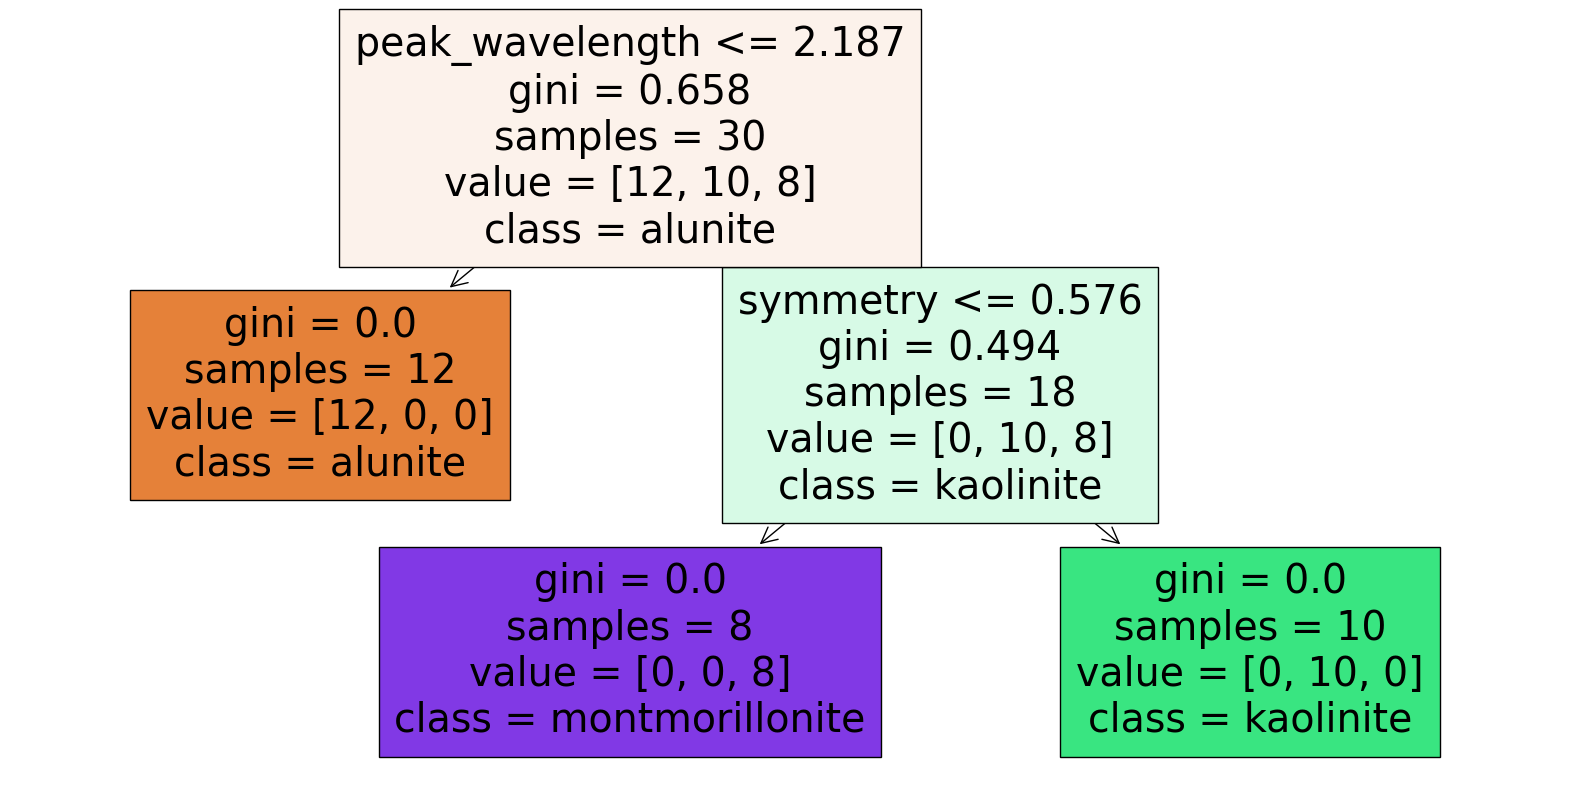

In [3]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print feature importances
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importance)

# Visualize the decision tree (optional)
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=features, class_names=class_names, filled=True)
plt.show()

In [15]:
# Producer's accuracy (Recall)
producer_acc_train = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# User's accuracy (Precision)
user_acc_train = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)

metrics_df_train = pd.DataFrame({
    'Class': class_names,
    'Producer Accuracy (Recall)': producer_acc_train.round(2),
    'User Accuracy (Precision)': user_acc_train.round(2)
})

print("Class-wise Accuracy Metrics:")
print(metrics_df_train.to_markdown(index=False), "\n")

Class-wise Accuracy Metrics:
| Class           |   Producer Accuracy (Recall) |   User Accuracy (Precision) |
|:----------------|-----------------------------:|----------------------------:|
| alunite         |                         1    |                        0.92 |
| kaolinite       |                         1    |                        1    |
| montmorillonite |                         0.89 |                        1    | 



In [4]:
test_data = pd.read_csv('test_3.csv')


# Apply range feature creation
range_features = test_data.apply(create_range_features, axis=1)
test_data = pd.concat([test_data, range_features], axis=1)

In [5]:
x_test_data = test_data[features]
y_test_data = test_data['mineral']

# 6. Encode labels and predict
y_test_data_encoded = label_encoder.transform(y_test_data)
y__test_data_pred_encoded = dt_model.predict(x_test_data)
y_test_data_pred = label_encoder.inverse_transform(y__test_data_pred_encoded)

Test Accuracy: 90.48%


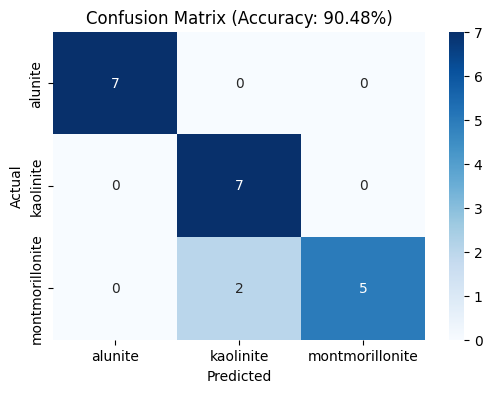

In [6]:
# 7. Evaluate
accuracy_test = accuracy_score(y_test_data_encoded, y__test_data_pred_encoded)
print(f"Test Accuracy: {accuracy_test:.2%}")

# Confusion matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test_data, y_test_data_pred, labels=label_encoder.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix (Accuracy: {accuracy_test:.2%})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [7]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true_labels, predictions)
print("Kappa Coefficient:", kappa)

Kappa Coefficient: 0.9510268562401264


In [8]:
from sklearn.metrics import classification_report

# Generate precision, recall, and F1 for all classes
report = classification_report(y_test_data_encoded, y__test_data_pred_encoded, target_names=["Kaolinite", "Montmorillonite", "Alunite"])
print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

      Kaolinite       1.00      1.00      1.00         7
Montmorillonite       0.78      1.00      0.88         7
        Alunite       1.00      0.71      0.83         7

       accuracy                           0.90        21
      macro avg       0.93      0.90      0.90        21
   weighted avg       0.93      0.90      0.90        21



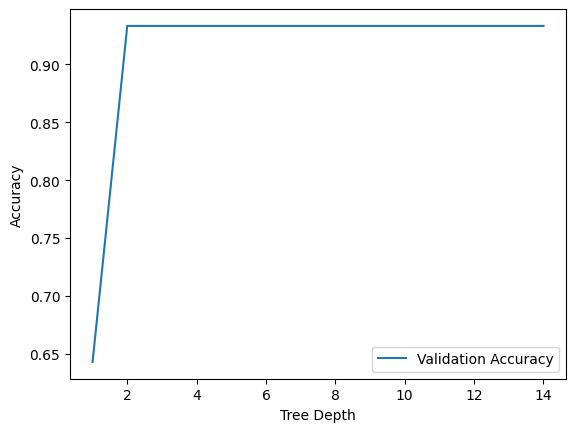

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

depths = range(1, 15)
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=48),
    X, y, param_name="max_depth", param_range=depths,
    cv=5, scoring="accuracy"
)

plt.plot(depths, np.mean(test_scores, axis=1), label="Validation Accuracy")
plt.xlabel("Tree Depth"); plt.ylabel("Accuracy"); plt.legend()
plt.show()

In [11]:
# Producer's accuracy (Recall)
producer_acc = np.diag(cm) / np.sum(cm, axis=1)

# User's accuracy (Precision)
user_acc = np.diag(cm) / np.sum(cm, axis=0)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Producer Accuracy (Recall)': producer_acc.round(2),
    'User Accuracy (Precision)': user_acc.round(2)
})


In [12]:
print("Class-wise Accuracy Metrics:")
print(metrics_df.to_markdown(index=False), "\n")

Class-wise Accuracy Metrics:
| Class           |   Producer Accuracy (Recall) |   User Accuracy (Precision) |
|:----------------|-----------------------------:|----------------------------:|
| alunite         |                         1    |                        1    |
| kaolinite       |                         1    |                        0.78 |
| montmorillonite |                         0.71 |                        1    | 

